## Import packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import IterableDataset
import torch.nn.init as init
import torch.optim as optim

from pyproj import CRS, Transformer

from datetime import datetime, timedelta
import time
from tqdm import tqdm

import os
import math
import numpy as np
import numpy.ma as ma
import pandas as pd

import xarray as xr
import rioxarray as rio
import pickle
import rasterio

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

from utils.data_utils import load_data, convert_tr_dt_to_dt, \
        process_lulc_data, remap_lulc_data, get_projection_string
from utils.model_utils import get_activation_function, get_optimizer
# Test data
from utils.test_uq import eval, eval_with_mcd
# Infer data
from utils.inference import run_inference
from utils.post_imputation import process_imputed_data, process_imputed_data_uq
from utils.visuals import create_plots
from utils.create_raster import create_xr, save_output

import matplotlib.pyplot as plt
import tempfile

In [2]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, xdata, ydata, mask, binary_mask, month_data, season_data):
        self.xdata = torch.tensor(np.nan_to_num(xdata, nan=-1.0), dtype=torch.float32)
        self.ydata = torch.tensor(np.nan_to_num(ydata, nan=-1.0), dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        self.binary_mask = torch.tensor(binary_mask, dtype=torch.float32)
        self.month_data = torch.tensor(month_data, dtype=torch.long)  
        self.season_data = torch.tensor(season_data, dtype=torch.long)
        # self.lulc_data = torch.tensor(lulc_data, dtype=torch.long)
        
    def __len__(self):
        return len(self.ydata)

    def __getitem__(self, idx):
         return {
                    'X': self.xdata[idx],
                    'Y': self.ydata[idx],
                    'M': self.mask[idx],
                    'binary_mask': self.binary_mask,
                    'month': self.month_data[idx], 
                    'season': self.season_data[idx]
                    # 'lulc': self.lulc_data
                }
        
def stream_data_loader(dataset, batch_size=1, shuffle=True):
    worker_init_fn = lambda _: np.random.seed()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, worker_init_fn=worker_init_fn)
    while True:
        for data in dataloader:
            yield data


class CustomIterableDataset(IterableDataset):
    def __init__(self, xdata, ydata, mask, binary_mask, month_data, season_data, lulc_data, date_data):
        # lulc_data
        self.xdata = torch.tensor(np.nan_to_num(xdata, nan=0.0), dtype=torch.float32)
        self.ydata = torch.tensor(np.nan_to_num(ydata, nan=0.0), dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        self.binary_mask = torch.tensor(binary_mask, dtype=torch.float32)
        # self.binary_mask = torch.tensor(binary_mask, dtype=torch.bool)
        self.month_data = torch.tensor(month_data, dtype=torch.long)
        self.season_data = torch.tensor(season_data, dtype=torch.long)
        self.lulc_data = torch.tensor(lulc_data, dtype=torch.long)
        self.date_data = np.array([date.timestamp() for date in date_data])  
        
    def process_item(self, idx):
        return {
            'X': self.xdata[idx],
            'Y': self.ydata[idx],
            'M': self.mask[idx],
            'binary_mask': self.binary_mask,
            'month': self.month_data[idx], 
            'season': self.season_data[idx],
            'date': self.date_data[idx],
            'lulc': self.lulc_data
        }

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  
            iter_start = 0
            iter_end = len(self.ydata)
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((len(self.ydata) / float(worker_info.num_workers))))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, len(self.ydata))

        return (self.process_item(idx) for idx in range(iter_start, iter_end))

In [18]:
class CustomLULCEmbedding(nn.Module):
    def __init__(self, num_lulc_classes, lulc_embed_dim):
        super().__init__()
        self.lulc_embedding = nn.Embedding(num_lulc_classes, lulc_embed_dim)
        # Explicitly zero out the first embedding vector which is typically used for padding
        self.lulc_embedding.weight.data[0].fill_(0)

    def forward(self, x):
        return self.lulc_embedding(x)

    @property
    def weight(self):
        return self.lulc_embedding.weight

    
class Generator(nn.Module):
    def __init__(self, in_channels, covariate_channels, activation_fn, 
                 num_lulc_classes, lulc_embed_dim=256,
                 num_months=12, month_embed_dim=24, 
                 num_seasons=4, season_embed_dim=8, 
                 dropout_rate = 0.2):

        super(Generator, self).__init__()
        
        # Embedding for months
        self.month_embedding = nn.Embedding(num_months, month_embed_dim)
        # Embedding for seasons
        self.season_embedding = nn.Embedding(num_seasons, season_embed_dim)
        # Embedding for LULC       
        self.lulc_embedding = CustomLULCEmbedding(num_lulc_classes, lulc_embed_dim)
        print('in, covariate, month, season, lulc')
        print(in_channels, covariate_channels, month_embed_dim, season_embed_dim, lulc_embed_dim) 
        total_channels = in_channels + 1 + covariate_channels   + month_embed_dim + season_embed_dim + lulc_embed_dim
        
        # Define the generator architecture with convolutional, batch normalization, and ReLU layers in sequence
        self.gen = nn.Sequential(
            nn.Conv2d(in_channels=total_channels, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),
            nn.Dropout2d(dropout_rate), 

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),
            nn.Dropout2d(dropout_rate), 

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),
            nn.Dropout2d(dropout_rate), 

            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Softplus()
        )

    def forward(self, corrupted_data, mask, covariates,  months, seasons, lulc_data, y_mask):
        # Extract height and width from corrupted_data
        height = corrupted_data.size(2)
        width = corrupted_data.size(3)

        # Ensure y_mask is of type long for compatibility with embedding tensors
        y_mask = y_mask.to(torch.long)
         
        # Get month embeddings
        month_embeddings = self.month_embedding(months)  # Shape: [batch_size, month_embed_dim]
        month_embeddings = month_embeddings.view(-1, month_embeddings.shape[1], 1, 1).repeat(1, 1, height, width)

        # Get season embeddings
        season_embeddings = self.season_embedding(seasons)  # Shape: [batch_size, season_embed_dim]
        season_embeddings = season_embeddings.view(-1, season_embeddings.shape[1], 1, 1).repeat(1, 1, height, width)

        # Get LULC embeddings
        lulc_embeddings = self.lulc_embedding(lulc_data)
        lulc_embeddings = lulc_embeddings.permute(0, 3, 1, 2) 

        # Concatenate mask and covariates with corrupted data along the channel dimension
        x = torch.cat([corrupted_data, mask, covariates, month_embeddings, season_embeddings, lulc_embeddings], dim=1)
        # Pass the concatenated input through the generator network
        x = self.gen(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels, activation_fn, dropout_rate = 0.1):
        super(Discriminator, self).__init__()

        # Define the discriminator architecture with convolutional, batch normalization, and ReLU layers in sequence
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride = 1, padding=1),
            activation_fn,
            nn.Dropout2d(dropout_rate), 

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride = 1, padding=1),
            activation_fn,
            nn.Dropout2d(dropout_rate), 

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride = 1, padding=1),
            activation_fn,
            nn.Dropout2d(dropout_rate), 
            
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride = 1, padding=1),
            nn.Sigmoid()
        )


    def forward(self, combined_input, hint):
        # Concatenate the combined input and hint along the channel dimension
        x = torch.cat([combined_input, hint], dim=1)
        # Pass the concatenated input through the discriminator network
        x = self.disc(x)
        return x


## Initialize file path and projection file

In [42]:
abbr_dict_region = {'Northeast': 'NE',
             'Upper Midwest': 'UM',
             'Ohio Valley': 'OV',
             'Southeast': 'SE',
             'South': 'S',
             'Southwest':'SW',
             'Northern Rockies': 'NR',
             'West': 'W',
             'Northwest': 'NW'}


region_name = 'Northeast'
region_abbr = abbr_dict_region.get(region_name)

# Read and process LULC data
lulc_filepath = f'/opt/yarn/ml-model/Ancillary_files/LULC/{region_name}/{region_abbr}_LULC.tif'
output_pkl =  f'/datastorage/Output/TrainingData/Pickle/{region_name}/Imputation/'
tif_path = f'/datastorage/Output/MODIS-MAIAC/Imputed/{region_name}/Version3/'

prj_file = '/opt/yarn/ml-model/Ancillary_files/Projection/lambert_conformal.prj'
prj_str = get_projection_string(prj_file)
crs = CRS.from_wkt(prj_str)
proj_string = crs.to_proj4()

p_hint = 0.2


/opt/miniconda/envs/aq-env/lib/python3.10/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


## uq metrics

In [5]:
z_score90 = 1.645
z_score95 = 1.96
z_score99 = 2.576

## Read pickle files

In [6]:
print("Loading datasets...")

# x_train_model = load_data(f'{output_pkl}/{region_abbr}_X_Train.pkl')
# x_train_model = x_train_model[0]
# y_train_model, miss_y_train_model = load_data(f'{output_pkl}/{region_abbr}_Y_Train.pkl')
# y_train_model = np.where((y_train_model == -9999) | (y_train_model == -1.0), np.nan, y_train_model)

# x_val_model = load_data(f'{output_pkl}/{region_abbr}_X_Validation.pkl')
# x_val_model = x_val_model[0]
# y_val_model, miss_y_val_model = load_data(f'{output_pkl}/{region_abbr}_Y_Validation.pkl')
# y_val_model = np.where((y_val_model == -9999) | (y_val_model == -1.0), np.nan, y_val_model)


x_test_model = load_data(f'{output_pkl}/{region_abbr}_X_Test.pkl')
x_test_model = x_test_model[0]
y_test_model, miss_y_test_model = load_data(f'{output_pkl}/{region_abbr}_Y_Test.pkl')
y_test_model = np.where((y_test_model == -9999) | (y_test_model == -1.0), np.nan, y_test_model)

d_train, d_test, d_val = load_data(f'{output_pkl}/{region_abbr}_DATE_TTV.pkl')
season_train, season_test, season_val = load_data(f'{output_pkl}/{region_abbr}_Season_TTV.pkl')
month_train, month_test, month_val = load_data(f'{output_pkl}/{region_abbr}_Month_TTV.pkl')
data_bm = load_data(f'{output_pkl}/{region_abbr}_BM.pkl')
latitude, longitude = load_data(f'{output_pkl}/{region_abbr}_Grid.pkl')
# y_scaler = load_data(f'{output_pkl}Y_scaler.pkl')
print("Datasets loaded.")

Loading datasets...
Loading data from /datastorage/Output/TrainingData/Pickle/Northeast/Imputation//NE_X_Test.pkl...
Loading data from /datastorage/Output/TrainingData/Pickle/Northeast/Imputation//NE_Y_Test.pkl...
Loading data from /datastorage/Output/TrainingData/Pickle/Northeast/Imputation//NE_DATE_TTV.pkl...
Loading data from /datastorage/Output/TrainingData/Pickle/Northeast/Imputation//NE_Season_TTV.pkl...
Loading data from /datastorage/Output/TrainingData/Pickle/Northeast/Imputation//NE_Month_TTV.pkl...
Loading data from /datastorage/Output/TrainingData/Pickle/Northeast/Imputation//NE_BM.pkl...
Loading data from /datastorage/Output/TrainingData/Pickle/Northeast/Imputation//NE_Grid.pkl...
Datasets loaded.


In [8]:
print(x_train_model.shape, y_train_model.shape, data_bm.shape)
t = 120
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

# Plot x_train_model in the first subplot
axes[0].imshow(x_train_model[t, 0, :])
axes[0].set_title("X - covariate")

# Plot y_train_model in the second subplot
axes[1].imshow(y_train_model[t, 0, :])
axes[1].set_title("y - target")

# Plot y_train_model in the second subplot
axes[2].imshow(miss_y_train_model[t, 0, :])
axes[2].set_title("y - mask")

# Plot y_train_model in the second subplot
axes[3].imshow(data_bm[0, :])
axes[3].set_title("study area mask")

# Display the plots
plt.show()

NameError: name 'x_train_model' is not defined

## Read LULC file

In [7]:
lulc_data, class_to_index = process_lulc_data(lulc_filepath)
lulc_data_remapped = remap_lulc_data(lulc_data, class_to_index)

lulc_remap_values = np.unique(lulc_data_remapped, return_counts = True)
lulc_actual_values = np.unique(lulc_data, return_counts = True)

num_lulc_classes = len(lulc_remap_values[0])
lulc_remap_values, lulc_actual_values, num_lulc_classes

((array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
        dtype=uint8),
  array([691866,  16706,  25807,  17174,  11574,   4797,   1429, 144983,
          42010,  78174,   4044,   4628,  40875,  30728,  35322,   5660])),
 (array([  0,  11,  21,  22,  23,  24,  31,  41,  42,  43,  52,  71,  81,
          82,  90,  95, 255], dtype=uint8),
  array([672384,  16706,  25807,  17174,  11574,   4797,   1429, 144983,
          42010,  78174,   4044,   4628,  40875,  30728,  35322,   5660,
          19482])),
 16)

In [8]:
lulc_data_remapped_int = lulc_data_remapped.astype(np.int32)

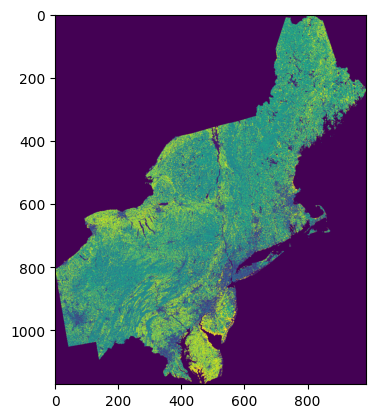

In [9]:
plt.imshow(lulc_data_remapped)

## Datasets and IterableDatasets

In [10]:
# Adjust month data and create datasets
# adj_month_train = month_train - 1
# adj_month_val = month_val - 1
adj_month_test = month_test - 1

# train_dataset = CustomIterableDataset(x_train_model, y_train_model, miss_y_train_model, data_bm[0], adj_month_train, season_train, lulc_data_remapped_int, d_train)
# val_dataset = CustomIterableDataset(x_val_model, y_val_model, miss_y_val_model, data_bm[0], adj_month_val, season_val, lulc_data_remapped_int, d_val)
test_dataset = CustomIterableDataset(x_test_model, y_test_model, miss_y_test_model, data_bm[0], adj_month_test, season_test, lulc_data_remapped_int, d_test)
print("Training and validation datasets prepared.")

Training and validation datasets prepared.


## Initialize parameters

In [11]:
p_hint = 0.2
####################################
batch_size = 32
num_epochs = 50
alpha = 0.05
beta = 0.05
activation_fn = get_activation_function('LeakyReLU')

optimizer_name_G = "AdamW"
optimizer_name_D = "SGD"
learning_rate_G = 0.00001
learning_rate_D = 0.00001
g_weight_decay = 1e-5
d_weight_decay = 1e-5
betas = [0.5, 0.999]

## Set file paths for metrics files, models, and figures

In [23]:
# f'/datastorage/Output/TrainingData/Pickle/{region_name}/Imputation/'

metrics_path = f'/datastorage/Output/Results/Imputation/{region_name}/TVT/'
models_path = f'/datastorage/Output/Models/Imputation/{region_name}/'
figures_path = f'/datastorage/Output/Figures/Imputation/{region_name}/'

## Get longs and lats to save the tif file¶

In [16]:
blh_fp = f'/opt/yarn/ml-model/Ancillary_files/Location/{region_name}/blh_2021001.tif'
print(blh_fp)
with rasterio.open(blh_fp) as src:
    blh_data = src.read(1)
    transform = src.transform  # Get the affine transformation
    width = src.width
    height = src.height

# Generate a grid of pixel coordinates
cols, rows = np.meshgrid(np.arange(width), np.arange(height))

# Transform pixel coordinates to spatial coordinates
xs, ys = rasterio.transform.xy(transform, rows, cols)

# Convert to numpy arrays
# lats = np.array(ys)
# longs = np.array(xs)

lats = np.array(ys).reshape(height, width)
longs = np.array(xs).reshape(height, width)

print("Latitude array shape:", lats.shape)
print("Longitude array shape:", longs.shape)

/opt/yarn/ml-model/Ancillary_files/Location/Northeast/blh_2021001.tif
Latitude array shape: (1171, 987)
Longitude array shape: (1171, 987)


## Data loaders

In [17]:
# train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size,num_workers=2)

In [27]:
#W: models/W_discriminator_1121.pth; 
#NE: models/generator_model_1005_v2.pth models/discriminator_model_1005_v2.pth
generator_path = f'{models_path}/generator_model_1005_v2.pth' 
discriminator_path = f'{models_path}/discriminator_model_1005_v2.pth' 

## Create datasets

In [20]:
print('1. Get the input shape dimensions')

# Get the first batch from the DataLoader
first_batch = next(iter(test_loader))
x_first_batch, y_first_batch = first_batch['X'], first_batch['Y']

# Extracting the shape of your input data
num_y_segments, in_channels, height, width = y_first_batch.shape
num_x_segments, x_channels, height, width = x_first_batch.shape

print('2. Set the model')
# Instantiate the Generator
generator = Generator(in_channels, x_channels, activation_fn, num_lulc_classes)   

# Instantiate the Discriminator
discriminator = Discriminator(in_channels, activation_fn = activation_fn)

print('3. Set the device')
use_gpu = torch.cuda.is_available()  # Automatically check if GPU is available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
torch.manual_seed(42)  # Set seed for CPU operations.
generator.to(device)
discriminator.to(device)

print('4. Set optimizer')
optimizer_G = get_optimizer(optimizer_name_G, generator.parameters(), learning_rate_G, g_weight_decay, betas, momentum=0.9)
optimizer_D = get_optimizer(optimizer_name_D, discriminator.parameters(), learning_rate_D, d_weight_decay, betas, momentum=0.9)

1. Get the input shape dimensions
2. Set the model
in, covariate, month, season, lulc
1 12 24 8 256
3. Set the device
4. Set optimizer


## Training loop

In [ ]:
iteration = 0

# Lists to store metrics for each mini-batch across all epochs
g_train_loss_history = []
d_train_loss_history = []
mse_train_loss_history = []
mae_train_loss_history = []

# Train - Lists to store average metrics per epoch
avg_g_train_loss_history = []
avg_d_train_loss_history = []
avg_mse_train_loss_history = []
avg_mae_train_loss_history = []
avg_rmse_train_loss_history = []

#  Validation - Lists to store average metrics per epoch
avg_g_val_loss_history = []
avg_d_val_loss_history = []
avg_mse_val_loss_history = []
avg_mae_val_loss_history = []
avg_rmse_val_loss_history = []

for epoch in range(num_epochs):

    # Initialize variables to track progress
    total_g_train_loss = 0
    total_d_train_loss = 0
    total_mse_train_loss = 0
    total_mae_train_loss = 0
    total_train_samples = 0

    # train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for i, batch_data in enumerate(train_loader):
        print('6. In model training phase')
        # Set models to training mode
        generator.train()
        discriminator.train()
   
        # Unpack the batch data
        Y_mb = batch_data['Y']  # observed data
        X_mb = batch_data['X'] #covariate
        M_mb = batch_data['M']  # The mask indicating observed data
        binary_mask = batch_data['binary_mask']
        month = batch_data['month']
        season = batch_data['season']
        lulc = batch_data['lulc']
        date_tensor = batch_data['date']
        
        dates = convert_date_tensor_to_datetime(date_tensor)

        # First, add a channel dimension to the mask, making it [batch_size, 1, height, width]
        binary_mask_expanded = binary_mask.unsqueeze(1) 
        binary_mask_x_expanded = binary_mask_expanded.expand(-1, in_channels, -1, -1) 
        binary_mask_y_expanded = binary_mask.unsqueeze(1)
        
        # Generate random noise Z_mb with the same shape as your data
        Z_mb = torch.rand_like(Y_mb) 

        # Generate hint matrix H_mb1 with a fraction of the observed data points hidden
        H_mb1 = sample_M(Y_mb.shape[0], Y_mb.shape[1:], 1 - p_hint)
        H_mb = M_mb * H_mb1

        # Combine the mask and the random noise to create New_X_mb
        New_Y_mb = M_mb * Y_mb + (1 - M_mb) * Z_mb  # Missing Data Introduction

        # Apply the ROI mask to ensure operations are only applied within the ROI
        New_Y_mb = New_Y_mb * binary_mask_y_expanded
        Y_mb = Y_mb * binary_mask_y_expanded
        X_mb = X_mb * binary_mask_x_expanded
        M_mb = M_mb * binary_mask_y_expanded
        H_mb = H_mb * binary_mask_y_expanded

        # Transfer to device (if using GPU)
        if use_gpu:
            Y_mb = Y_mb.to("cuda")
            X_mb = X_mb.to("cuda")
            M_mb = M_mb.to("cuda")
            H_mb = H_mb.to("cuda")
            New_Y_mb = New_Y_mb.to("cuda")

        # Discriminator - Reset gradients and calculate losses and perform backpropagation
        optimizer_D.zero_grad()
        D_loss, G_sample = discriminator_loss(generator, discriminator, X_mb, M_mb, New_Y_mb, H_mb, binary_mask_y_expanded, binary_mask_x_expanded, month, season, lulc)
        D_loss.backward()

        # Zero out gradients for LULC embedding indices 0 and 255
        if generator.lulc_embedding.weight.grad is not None:
            generator.lulc_embedding.weight.grad[0].fill_(0) 
            
        optimizer_D.step()
        
        # Generator - Reset gradients and calculate losses and perform backpropagation
        optimizer_G.zero_grad()
        G_loss, Adv_loss, MSE_train_loss, MAE_train_loss, G_sample = generator_loss(generator, discriminator, X_mb, Y_mb, M_mb, New_Y_mb, H_mb, binary_mask_y_expanded, binary_mask_x_expanded, month, season, lulc, alpha, beta)       
        G_loss.backward()

        # Zero out gradients for LULC embedding indices 0 and 255
        if generator.lulc_embedding.weight.grad is not None:
            generator.lulc_embedding.weight.grad[0].fill_(0) 
        
        optimizer_G.step()

        # Training - Update running totals
        total_g_train_loss += G_loss.item()
        total_d_train_loss += D_loss.item()
        
        total_mse_train_loss += MSE_train_loss.item() * Y_mb.size(0) 
        total_mae_train_loss += MAE_train_loss.item() * Y_mb.size(0)
        total_train_samples += Y_mb.size(0)
        
        # Append the generator and discriminator losses for visualization
        g_train_loss_history.append(G_loss.item())
        d_train_loss_history.append(D_loss.item())
        mse_train_loss_history.append(MSE_train_loss.item())
        mae_train_loss_history.append(MAE_train_loss.item())
        
        iteration += 1

        print(f'Epoch {epoch} - batch {i} Generator loss: {G_loss.item():.4f}, D_loss: {D_loss.item():.4f}, Adversarial_train_loss: {Adv_loss.item():.4f}, MSE_train_loss: {MSE_train_loss.item():.4f}, MAE_train_loss: {MAE_train_loss.item():.4f}')

    # Calculate average losses for the epoch
    avg_g_train_loss = total_g_train_loss / total_train_samples
    avg_d_train_loss = total_d_train_loss / total_train_samples
    avg_train_mse = total_mse_train_loss / total_train_samples
    avg_train_mae = total_mae_train_loss / total_train_samples
    avg_train_rmse = np.sqrt(total_mse_train_loss / total_train_samples)
    
    # At the end of the epoch, append the averages
    avg_g_train_loss_history.append(avg_g_train_loss)
    avg_d_train_loss_history.append(avg_d_train_loss)
    avg_mse_train_loss_history.append(avg_train_mse)
    avg_mae_train_loss_history.append(avg_train_mae)
    avg_rmse_train_loss_history.append(avg_train_rmse)

    print(f'Epoch {epoch} | Average train G_loss: {avg_g_train_loss:.4f}, D_loss: {avg_d_train_loss:.4f}, MSE_train: {avg_train_mse:.4f}, MAE_train: {avg_train_mae:.4f}, RMSE_train: {avg_train_rmse:.4f}')

    print('===========================================================')
    print('7. In model validation phase')
    # Switch to evaluation mode for validation
    generator.eval()
    discriminator.eval()
    
    total_g_val_loss = 0
    total_d_val_loss = 0
    total_mse_val_loss = 0
    total_mae_val_loss = 0
    total_val_samples = 0
    
    with torch.no_grad():  # No gradients needed for evaluation
        for i, batch_data in enumerate(val_loader):
            print(f'epoch {epoch} batch data {i}')
            X_mb = batch_data['X'].to(device)
            M_mb = batch_data['M'].to(device)
            Y_mb = batch_data['Y'].to(device)
            binary_mask = batch_data['binary_mask']
            month = batch_data['month']
            season = batch_data['season']
            lulc = batch_data['lulc']

            # First, add a channel dimension to the mask, making it [batch_size, 1, height, width]
            binary_mask_expanded = binary_mask.unsqueeze(1) 
            binary_mask_x_expanded = binary_mask_expanded.expand(-1, x_channels, -1, -1) 
            binary_mask_y_expanded = binary_mask.unsqueeze(1)

            # Generate random noise Z_mb with the same shape as your data
            Z_mb = torch.rand_like(Y_mb)

            # Generate hint matrix H_mb1 with a fraction of the observed data points hidden
            H_mb1 = sample_M(Y_mb.shape[0], Y_mb.shape[1:], 1 - p_hint)
            H_mb = M_mb * H_mb1

            # Combine the mask and the random noise to create New_X_mb
            New_Y_mb = M_mb * Y_mb + (1 - M_mb) * Z_mb  # Missing Data Introduction

            # Apply the ROI mask to ensure operations are only applied within the ROI
            New_Y_mb = New_Y_mb * binary_mask_y_expanded
            X_mb = X_mb * binary_mask_x_expanded
            M_mb = M_mb * binary_mask_y_expanded
            H_mb = H_mb * binary_mask_y_expanded

            # Discriminator loss
            D_loss, G_sample = discriminator_loss(generator, discriminator, X_mb, M_mb, New_Y_mb, H_mb, binary_mask_y_expanded, binary_mask_x_expanded, month, season, lulc)
            # Generator loss
            G_loss, Adv_loss, MSE_val_loss, MAE_val_loss, G_sample = generator_loss(generator, discriminator, X_mb, Y_mb, M_mb, New_Y_mb, H_mb, binary_mask_y_expanded, binary_mask_x_expanded, month, season, lulc, alpha, beta)

            # Validation - Update running totals
            total_g_val_loss += G_loss.item()
            total_d_val_loss += D_loss.item()
            total_mse_val_loss += MSE_val_loss.item() * Y_mb.size(0)  
            total_mae_val_loss += MAE_val_loss.item() * Y_mb.size(0)
            total_val_samples += Y_mb.size(0)
            
        avg_g_val_loss = total_g_val_loss / total_val_samples
        avg_d_val_loss = total_d_val_loss / total_val_samples
        avg_val_mse = total_mse_val_loss / total_val_samples
        avg_val_mae = total_mae_val_loss / total_val_samples
        avg_val_rmse = np.sqrt(total_mse_val_loss / total_val_samples) 
        avg_val_mae = total_mae_val_loss / total_val_samples
        
        # At the end of the epoch, append the averages
        avg_g_val_loss_history.append(avg_g_val_loss)
        avg_d_val_loss_history.append(avg_d_val_loss)
        avg_mse_val_loss_history.append(avg_val_mse)
        avg_mae_val_loss_history.append(avg_val_mae)
        avg_rmse_val_loss_history.append(avg_val_rmse)

        print(f'Epoch {epoch} | Average val G_loss: {avg_g_val_loss:.4f}, D_loss: {avg_d_val_loss:.4f},MSE_val: {avg_val_mse:.4f}, MAE_val: {avg_val_mae:.4f}, RMSE_val: {avg_val_rmse:.4f}')
        print('\n')

## Run this code with caution - DON'T RUN ME WITHOUT THINKING!

In [ ]:
# Save the generator model
torch.save(generator.state_dict(), generator_path)

# Save the discriminator model
torch.save(discriminator.state_dict(), discriminator_path)

In [ ]:
# Create a dictionary to form DataFrame columns
data1 = {
    "Train MSE": avg_mse_train_loss_history,
    "Val MSE": avg_mse_val_loss_history
}

# Create a dictionary to form DataFrame columns
data2 = {
    "Train MAE": avg_mae_train_loss_history,
    "Val MAE": avg_mae_val_loss_history
}

# Create a DataFrame from the lists
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Specify the file name
csv_file1 = f"{metrics_path}{region_abbr}_LC_MSE.csv"
csv_file2 = f"{metrics_path}{region_abbr}_LC_MAE.csv"

# Save DataFrame to CSV
df1.to_csv(csv_file1, index=False)
df2.to_csv(csv_file2, index=False)

## Learning curve - train and validation loss

In [ ]:
# Number of epochs corresponds to the length of the lists
epochs = range(1, len(avg_mse_train_loss_history) + 1)

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the MSE learning curve
axs[0].plot(epochs, avg_mse_train_loss_history, 'b-', marker='o', label='Training MSE')
axs[0].plot(epochs, avg_mse_val_loss_history, 'r-', marker='o', label='Validation MSE')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')
axs[0].set_title('MSE over Epochs')
axs[0].legend()
axs[0].grid(True)

# Plotting the MAE learning curve
axs[1].plot(epochs, avg_mae_train_loss_history, 'b-', marker='o', label='Training MAE')
axs[1].plot(epochs, avg_mae_val_loss_history, 'r-', marker='o', label='Validation MAE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('MAE over Epochs')
axs[1].legend()
axs[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

## Loads the saved model for evaluation and inference

In [29]:
# generator.load_state_dict(torch.load(generator_path, map_location=torch.device('cpu')))
# discriminator.load_state_dict(torch.load(discriminator_path, map_location=torch.device('cpu')))

generator.load_state_dict(torch.load(generator_path, map_location="cpu", weights_only=True))
discriminator.load_state_dict(torch.load(discriminator_path, map_location="cpu", weights_only=True))

<All keys matched successfully>

## Call the evaluation mode

In [ ]:
# imputed_train_data_samples, gain_train_data_samples, y_train_samples, train_date_list, train_y_mask_list, train_metrics_df = eval(train_loader, generator, discriminator, p_hint, alpha, beta, device)
# imputed_val_data_samples, gain_val_data_samples, y_val_samples, val_date_list, val_y_mask_list, val_metrics_df = eval(val_loader, generator, discriminator, p_hint, alpha, beta, device)
imputed_test_data_samples, gain_test_data_samples, y_test_samples, test_date_list, test_y_mask_list, test_metrics_df = eval(test_loader, generator, discriminator, p_hint, alpha, beta, device)

## Save train validation and test metrics

In [ ]:
train_metrics_df.to_csv(f'{region_abbr}_train_metrics.csv')
val_metrics_df.to_csv(f'{region_abbr}_val_metrics.csv')
test_metrics_df.to_csv(f'{region_abbr}_test_metrics.csv')

## Process imputed data - sort dates and mask the ROI

In [ ]:
# imputed_train_aod, gain_train_imputed_aod, y_train_data, sorted_train_dates = process_imputed_data(imputed_train_data_samples, gain_train_data_samples, miss_y_train_model, y_train_samples, train_date_list, data_bm[0])
# imputed_val_aod, gain_val_imputed_aod, y_val_data, sorted_val_dates = process_imputed_data(imputed_val_data_samples, gain_val_data_samples, miss_y_val_model, y_val_samples, val_date_list, data_bm[0])
imputed_test_aod, gain_test_imputed_aod, y_test_data, sorted_test_dates = process_imputed_data(imputed_test_data_samples, gain_test_data_samples, miss_y_test_model, y_test_samples, test_date_list, data_bm[0])

## Create plots

In [ ]:
date = datetime(2022, 8, 8, 0, 0)  # Replace with the desired date
# create_plots(imputed_train_aod, gain_train_imputed_aod, y_train_data, miss_y_train_model, sorted_train_dates, date, 'rainbow')
# create_plots(imputed_val_aod, gain_val_imputed_aod, y_val_data, miss_y_val_model, sorted_val_dates, date, 'rainbow')
create_plots(imputed_test_aod, gain_test_imputed_aod, y_test_data, miss_y_test_model, sorted_test_dates, date, 'rainbow')

## Save imputed tif data for train test and validation
* create xarray dataset
* save the xarray dataset as raster

In [ ]:
import os
if not os.path.exists(f'/data/Imputation/{region_name}/Output/Version1/TIF/GAIN/NonRT/'):
    os.makedirs(f'/data/Imputation/{region_name}/Output/Version1/TIF/GAIN/NonRT/')
train_imputed_xr = transform_and_create_dataset(gain_train_imputed_aod, d_train, longs, lats, proj_string)
save_output(f'{tif_path}/GAIN/NonRT/', train_imputed_xr)
val_imputed_xr = transform_and_create_dataset(gain_val_imputed_aod, d_val, longs, lats, proj_string)
save_output(f'{tif_path}/GAIN/NonRT/', val_imputed_xr)
test_imputed_xr = transform_and_create_dataset(gain_test_imputed_aod, d_test, longs, lats, proj_string)
save_output(f'{tif_path}/GAIN/NonRT/', test_imputed_xr)

In [ ]:
if not os.path.exists(f'/data/Imputation/{region_name}/Output/Version1/TIF/Merged/NonRT/'):
    os.makedirs(f'/data/Imputation/{region_name}/Output/Version1/TIF/Merged/NonRT/')
train_imputed_xr = transform_and_create_dataset(imputed_train_aod, d_train, longs, lats, proj_string)
save_output(f'{tif_path}/Merged/NonRT/', train_imputed_xr)
val_imputed_xr = transform_and_create_dataset(imputed_val_aod, d_val, longs, lats, proj_string)
save_output(f'{tif_path}/Merged/NonRT/', val_imputed_xr)
test_imputed_xr = transform_and_create_dataset(imputed_test_aod, d_test, longs, lats, proj_string)
save_output(f'{tif_path}/Merged/NonRT/', test_imputed_xr)

## Evaluate with UQ 

In [ ]:
uq_gain_data_samples, uq_variance_data_samples,  lower_bound_samples, upper_bound_samples, uq_y_actual_samples, uq_y_mask_list, uq_date_list = eval_with_mcd(test_loader, generator, discriminator, p_hint, alpha, beta, z_score99, device, num_samples=10)

## Process imputed data with UQ - sort dates and mask the ROI

In [ ]:
gain_imputed_test_aod, var_test_aod, lower_bound_test_aod, upper_bound_test_aod, actual_test_aod, sorted_test_dates = process_imputed_data_uq(uq_gain_data_samples, uq_variance_data_samples, lower_bound_samples, upper_bound_samples, uq_y_actual_samples, miss_y_test_model, uq_date_list, data_bm[0])

In [ ]:
pi_width = upper_bound_test_aod - lower_bound_test_aod

In [ ]:
pi_width_mean = pi_width.mean(axis=0) 

## Save uncertainty quantified data as tif data for test data
* create xarray dataset
* save the xarray dataset as rasterer

In [ ]:
import os
if not os.path.exists(f'{tif_path}/GAIN/NonRT/'):
    os.makedirs(f'{tif_path}/GAIN/NonRT/')
train_imputed_xr = transform_and_create_dataset(gain_train_imputed_aod, d_train, longs, lats, proj_string)
save_output(f'{tif_path}/GAIN/NonRT/', train_imputed_xr)
val_imputed_xr = transform_and_create_dataset(gain_val_imputed_aod, d_val, longs, lats, proj_string)
save_output(f'{tif_path}/GAIN/NonRT/', val_imputed_xr)
test_imputed_xr = transform_and_create_dataset(gain_test_imputed_aod, d_test, longs, lats, proj_string)
save_output(f'{tif_path}/GAIN/NonRT/', test_imputed_xr)

In [22]:
with open(f'{output_pkl}/{region_abbr}_X_Infer_{infer_year}.pkl', 'rb') as f:
    x_data_model = pickle.load(f)

## Read the inference data

In [30]:
infer_year = 2024
# Load X and Y datasets
with open(f'{output_pkl}/{region_abbr}_X_Infer_{infer_year}.pkl', 'rb') as f:
    x_data_model = pickle.load(f)

# Load X and Y datasets
with open(f'{output_pkl}/{region_abbr}_Y_Infer_{infer_year}.pkl', 'rb') as f:
   y_data_model, miss_matrix_model = pickle.load(f)

# Load date arrays
with open(f'{output_pkl}/{region_abbr}_DATE_Infer_{infer_year}.pkl', 'rb') as f:
    date_arr = pickle.load(f)

# Load binary mask
with open(f'{output_pkl}/{region_abbr}_BM_Infer_{infer_year}.pkl', 'rb') as f:
    data_bm = pickle.load(f)

# Load grid information (latitude and longitude)
with open(f'{output_pkl}/{region_abbr}_Grid_Infer_{infer_year}.pkl', 'rb') as f:
    latitude, longitude = pickle.load(f)

# Load season array
with open(f'{output_pkl}/{region_abbr}_Season_Infer_{infer_year}.pkl', 'rb') as f:
    season_arr = pickle.load(f)

# Load month array
with open(f'{output_pkl}/{region_abbr}_Month_Infer_{infer_year}.pkl', 'rb') as f:
    month_arr = pickle.load(f)

## Create infer dataset

In [31]:
bm = data_bm[0]
adj_month_arr = month_arr - 1
infer_dataset = CustomIterableDataset(x_data_model[0], y_data_model, miss_matrix_model, bm, adj_month_arr, season_arr, lulc_data_remapped, date_arr[0])

In [32]:
infer_loader = DataLoader(infer_dataset, batch_size=batch_size, num_workers=2)

In [33]:
# Get the first batch from the DataLoader
first_batch = next(iter(infer_loader))
x_first_batch, y_first_batch = first_batch['X'], first_batch['Y']

# Extracting the shape of your input data
num_y_segments, in_channels, height, width = y_first_batch.shape
num_x_segments, x_channels, height, width = x_first_batch.shape

In [34]:
# Instantiate the Generator and Discriminator
generator = Generator(in_channels, x_channels, activation_fn, num_lulc_classes)
discriminator = Discriminator(in_channels, activation_fn=activation_fn)

in, covariate, month, season, lulc
1 12 24 8 256


In [35]:
# Load the saved weights into the model - make sure to map the location to CPU if you're not using GPU for inference
generator.load_state_dict(torch.load(generator_path, map_location=torch.device('cpu')))
discriminator.load_state_dict(torch.load(discriminator_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode before inference
generator.eval()

/tmp/ipykernel_19553/3920883792.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path, map_location=torch.device('cpu')))
/

Generator(
  (month_embedding): Embedding(12, 24)
  (season_embedding): Embedding(4, 8)
  (lulc_embedding): CustomLULCEmbedding(
    (lulc_embedding): Embedding(16, 256)
  )
  (gen): Sequential(
    (0): Conv2d(302, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(32, 1, kernel_

## Run the inference

In [36]:
imputed_infer_data_samples, gain_infer_data_samples, y_infer_samples, infer_date_list, infer_y_mask_list,all_metrics_df = run_inference(infer_loader, generator, discriminator, p_hint, alpha, beta, device)

/datastorage/Script/1_Imputation_Modeling/utils/metrics.py:53: RuntimeWarning: Mean of empty slice
  df_metrics['MAE'].append(np.nanmean(metrics['MAE']))
/datastorage/Script/1_Imputation_Modeling/utils/metrics.py:54: RuntimeWarning: Mean of empty slice
  df_metrics['MSE'].append(np.nanmean(metrics['MSE']))
/datastorage/Script/1_Imputation_Modeling/utils/metrics.py:55: RuntimeWarning: Mean of empty slice
  df_metrics['RMSE'].append(np.nanmean(metrics['RMSE']))
/datastorage/Script/1_Imputation_Modeling/utils/metrics.py:56: RuntimeWarning: Mean of empty slice
  df_metrics['Correlation'].append(np.nanmean(metrics['Correlation']))
/datastorage/Script/1_Imputation_Modeling/utils/metrics.py:53: RuntimeWarning: Mean of empty slice
  df_metrics['MAE'].append(np.nanmean(metrics['MAE']))
/datastorage/Script/1_Imputation_Modeling/utils/metrics.py:54: RuntimeWarning: Mean of empty slice
  df_metrics['MSE'].append(np.nanmean(metrics['MSE']))
/datastorage/Script/1_Imputation_Modeling/utils/metrics.py

Average test G_loss: 0.0061
Average test D_loss: 0.0091
Average test MSE: 0.0099
Average test MAE: 0.0763
Average test RMSE: 0.0993


## Save inference metrics

In [37]:
all_metrics_df.to_csv(f'{metrics_path}/{region_abbr}_infer_metrics_2024.csv')

## Process imputed data - sort dates and mask the ROI

In [38]:
imputed_infer_aod, gain_infer_imputed_aod, y_infer_data, sorted_infer_dates = process_imputed_data(imputed_infer_data_samples, gain_infer_data_samples, miss_matrix_model, y_infer_samples, infer_date_list, data_bm[0])

## Create plots

Merged imputed aod min: 0.0 max: 0.77071583
GAIN imputed aod min: 0.02343375 max: 0.77071583
Actual aod min: 0.0 max: 0.498


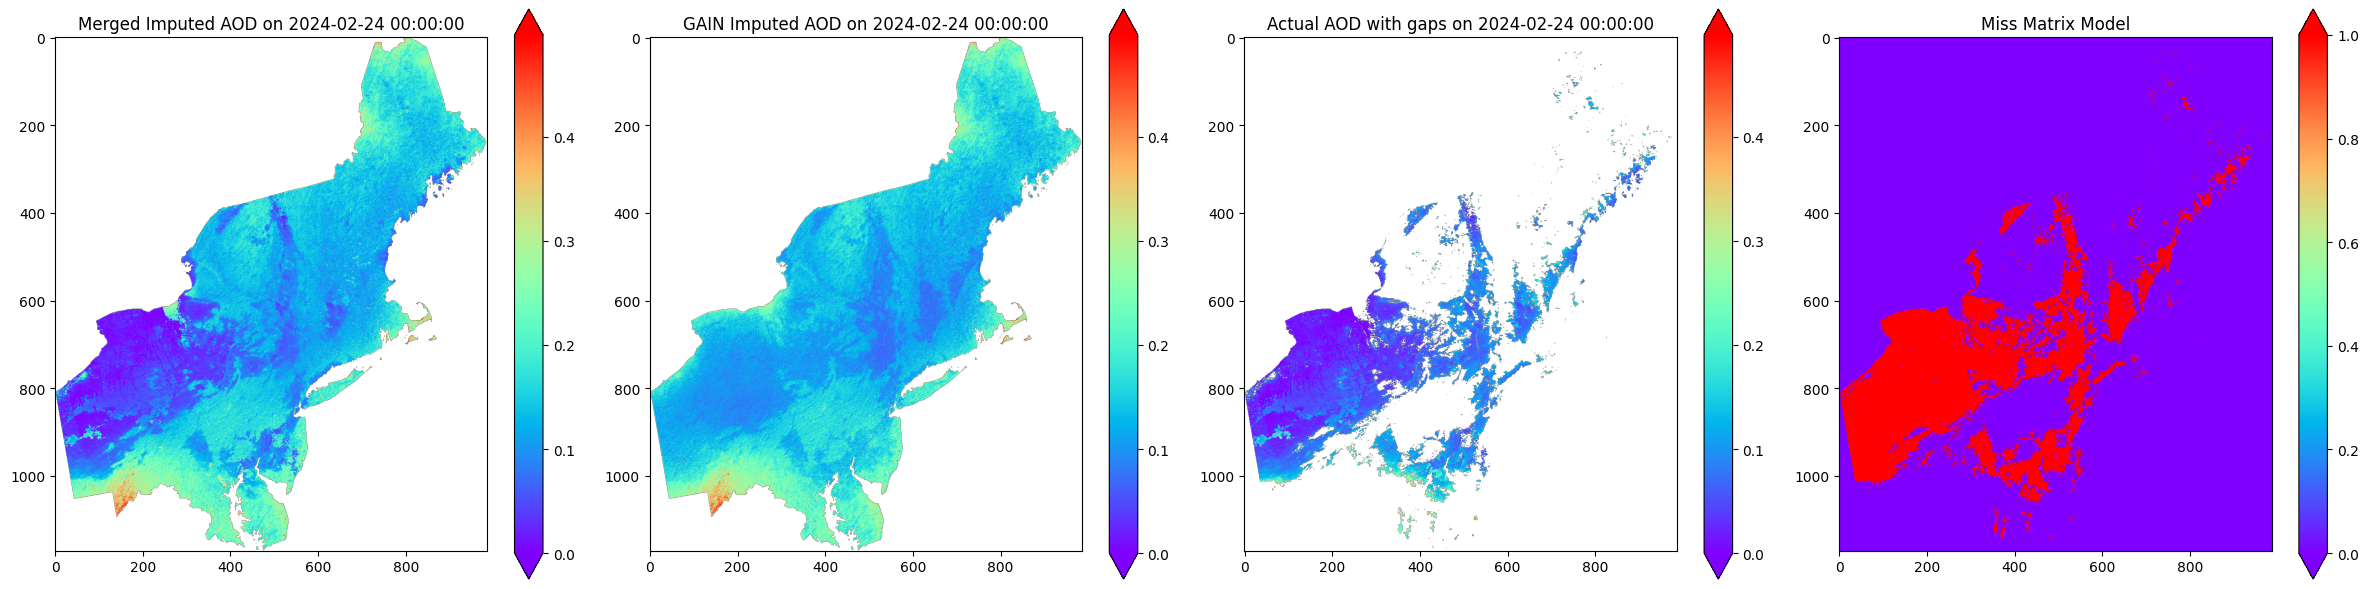

In [39]:
date = datetime(2024, 2, 24, 0, 0)  # Replace with the desired date
create_plots(imputed_infer_aod, gain_infer_imputed_aod, y_infer_data, miss_matrix_model, sorted_infer_dates, date, 'rainbow')

## Save imputed inference dataset

In [44]:
tif_path, infer_year

('/datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3/', 2024)

In [45]:
infer_imputed_xr = create_xr(gain_infer_imputed_aod, date_arr[0], longs, lats, proj_string)
save_output(f'{tif_path}/GAIN/{infer_year}/', infer_imputed_xr)

<class 'xarray.core.dataset.Dataset'>
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024001_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024002_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024003_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024004_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024005_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024006_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024007_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024008_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//GAIN/2024/MAIAC_2024009_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Versi

In [47]:
infer_imputed_xr = create_xr(imputed_infer_aod, date_arr[0], longs, lats, proj_string)
save_output(f'{tif_path}/Merged/{infer_year}/', infer_imputed_xr)

<class 'xarray.core.dataset.Dataset'>
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024001_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024002_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024003_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024004_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024005_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024006_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024007_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024008_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imputed/Northeast/Version3//Merged/2024/MAIAC_2024009_GAIN.tif
Saving /datastorage/Output/MODIS-MAIAC/Imput

In [ ]:
from utils.model_utils import sample_M
def enable_dropout(model):
    """Function to enable dropout layers during evaluation."""
    for module in model.modules():
        if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
            module.train()  

def eval_with_mcd(loader, generator, discriminator, p_hint, alpha, beta, z_score, device, num_samples=10):
    generator.eval()  # Set the generator to evaluation mode
    discriminator.eval()  # Set the discriminator to evaluation mode
    
    # Enable dropout layers during evaluation
    enable_dropout(generator)

    gain_data_samples = []
    variance_data_samples = []
    lower_bound_samples = []
    upper_bound_samples = []
    y_actual_samples = []
    date_list = []
    y_mask_list = []

    # all_metrics_df = pd.DataFrame()

    with torch.no_grad():  # No gradients needed for evaluation
        for batch_data in loader:
            
            X_mb = batch_data['X'].to(device)
            M_mb = batch_data['M'].to(device)
            Y_mb = batch_data['Y'].to(device)
            binary_mask = batch_data['binary_mask']
            month = batch_data['month']
            season = batch_data['season']
            lulc = batch_data['lulc']
            date_tensor = batch_data['date']

            dates = convert_tr_dt_to_dt(date_tensor)

            num_x_segments, x_channels, height, width = X_mb.shape
            num_y_segments, in_channels, height, width = Y_mb.shape

            # First, add a channel dimension to the mask, making it [batch_size, 1, height, width]
            binary_mask_expanded = binary_mask.unsqueeze(1) 
            binary_mask_x_expanded = binary_mask_expanded.expand(-1, x_channels, -1, -1) 
            binary_mask_y_expanded = binary_mask.unsqueeze(1)

            # Generate random noise Z_mb with the same shape as your data
            Z_mb = torch.rand_like(Y_mb)

            # Generate hint matrix H_mb1 with a fraction of the observed data points hidden
            H_mb1 = sample_M(Y_mb.shape[0], Y_mb.shape[1:], 1 - p_hint)
            H_mb = M_mb * H_mb1

            # Combine the mask and the random noise to create New_X_mb
            New_Y_mb = M_mb * Y_mb + (1 - M_mb) * Z_mb  # Missing Data Introduction

            # Apply the ROI mask to ensure operations are only applied within the ROI
            New_Y_mb = New_Y_mb * binary_mask_y_expanded
            X_mb = X_mb * binary_mask_x_expanded
            M_mb = M_mb * binary_mask_y_expanded
            H_mb = H_mb * binary_mask_y_expanded

            # Verify if dropout layers are in training mode
            for m in generator.modules():
                if isinstance(m, torch.nn.Dropout) or isinstance(m, torch.nn.Dropout2d):
                    print(f"Dropout layer {m} in training mode: {m.training}")

            # Perform multiple stochastic forward passes to capture uncertainty
            all_imputed_samples = []
            for i in range(num_samples):
                print(f'running the sample {i}')
                Imputed_Y_mb = generator(New_Y_mb * binary_mask_y_expanded, 
                                         M_mb * binary_mask_y_expanded, 
                                         X_mb * binary_mask_x_expanded, 
                                         month, season, lulc, binary_mask_y_expanded).detach()
                Imputed_Y_mb *= binary_mask_y_expanded  # Mask out outside ROI
                all_imputed_samples.append(Imputed_Y_mb)

            # Stack the predictions using torch.stack
            all_imputed_samples = torch.stack(all_imputed_samples, dim=0)
            binary_mask_y_expanded = binary_mask_y_expanded.unsqueeze(0).expand(all_imputed_samples.shape)
            
            nan_mask = ~binary_mask_y_expanded.bool()  # Identify outside-ROI pixels
            all_imputed_samples[nan_mask] = float('nan')

            # Optional way
            # Calculate the mean and variance along the first dimension (stochastic passes)
            # mean_imputed_Y_mb = torch.nanmean(all_imputed_samples, dim=0)
            # variance_imputed_Y_mb = torch.nanvar(all_imputed_samples, dim=0)
            # std_imputed_Y_mb = torch.nanstd(all_imputed_samples, dim=0)
            # lower_bound = mean_imputed_Y_mb - z_score * std_imputed_Y_mb
            # upper_bound = mean_imputed_Y_mb + z_score * std_imputed_Y_mb

            valid_mask = binary_mask_y_expanded.bool() 
            mean_imputed_Y_mb = torch.sum(all_imputed_samples * valid_mask, dim=0) / valid_mask.sum(dim=0)
            variance_imputed_Y_mb = torch.sum(((all_imputed_samples - mean_imputed_Y_mb) ** 2) * valid_mask, dim=0) / valid_mask.sum(dim=0)
            std_imputed_Y_mb = torch.sqrt(
                torch.sum(((all_imputed_samples - mean_imputed_Y_mb) ** 2) * valid_mask, dim=0) / valid_mask.sum(dim=0)
            )
            lower_bound = mean_imputed_Y_mb - z_score * std_imputed_Y_mb
            upper_bound = mean_imputed_Y_mb + z_score * std_imputed_Y_mb

            # Compute single scalar values
            mean_value = torch.nanmean(mean_imputed_Y_mb).item()
            var_value = torch.nanmean(variance_imputed_Y_mb).item()
            std_value = torch.nanmean(std_imputed_Y_mb).item() 
            # Compute single scalar values while ignoring NaNs
            lb_value = torch.nanmean(lower_bound).item()
            ub_value = torch.nanmean(upper_bound).item()
            
            # Print the values
            print(f"Mean: {mean_value}, Variance: {var_value}, Standard deviation: {std_value}, lower bound: {lb_value}, upper bound: {ub_value}")

            # Integrate imputed and observed data
            # Final_Imputed_Y_mb = M_mb * Y_mb + (1 - M_mb) * mean_imputed_Y_mb
            # Final_Imputed_Y_mb *= binary_mask_y_expanded  # Mask out pixels outside the ROI
            # mean_imputed_Y_mb *= binary_mask_y_expanded 
            # variance_imputed_Y_mb *= binary_mask_y_expanded
            # std_imputed_Y_mb *= binary_mask_y_expanded
    
            # Store the mean imputed values and uncertainty
            # imputed_data_samples.append(Final_Imputed_Y_mb.cpu().numpy()) 
            gain_data_samples.append(mean_imputed_Y_mb.cpu().numpy())
            variance_data_samples.append(variance_imputed_Y_mb.cpu().numpy())
            lower_bound_samples.append(lower_bound.cpu().numpy())
            upper_bound_samples.append(upper_bound.cpu().numpy())
            y_actual_samples.append(Y_mb.cpu().numpy())
            y_mask_list.append(M_mb)
            date_list.extend(dates)

            # Optionally, calculate any metrics (like RMSE) using the mean imputed values
            # batch_metrics_df = calc_metrics(dates, M_mb,mean_imputed_Y_mb, Y_mb.cpu())
            # all_metrics_df = pd.concat([all_metrics_df, batch_metrics_df], ignore_index=True)

            # total_test_samples += Y_mb.size(0)
    
    return gain_data_samples, variance_data_samples, lower_bound_samples, upper_bound_samples, y_actual_samples, y_mask_list, date_list 

## Uncertainty quantification using MCD
* Evaluation with MCD

In [ ]:
uq_gain_infer_samples, uq_variance_infer_samples, lower_bound_infer_samples, upper_bound_infer_samples, uq_y_actual_infer_samples, uq_y_mask_infer_list, uq_date_infer_list  = eval_with_mcd(infer_loader, generator, discriminator, p_hint, alpha, beta, z_score99, device, num_samples=10)

In [ ]:

def process_imputed_data_uq(gain_data_samples, variance_data_samples, lower_data_samples, upper_data_samples, y_actual_samples, miss_data, all_dates, bm):
    
    gain_concat = np.concatenate(gain_data_samples, axis=0)
    var_concat = np.concatenate(variance_data_samples, axis=0)
    lower_b_concat = np.concatenate(lower_data_samples, axis=0)
    upper_b_concat = np.concatenate(upper_data_samples, axis=0)
    y_concat = np.concatenate(y_actual_samples, axis = 0)

    total_days, channels, height, width = var_concat.shape

    combined = list(zip(all_dates, gain_concat, var_concat, lower_b_concat, upper_b_concat, y_concat))
    combined.sort(key=lambda x: x[0])
    sorted_dates, sorted_gain_concat, sorted_var_concat, sorted_lower_data, sorted_upper_data, sorted_y_data = zip(*combined)

    sorted_gain_concat = np.array(sorted_gain_concat)
    sorted_var_concat = np.array(sorted_var_concat)
    sorted_lower_data = np.array(sorted_lower_data)
    sorted_upper_data = np.array(sorted_upper_data)
    sorted_y_data = np.array(sorted_y_data)

    expanded_bm = np.expand_dims(np.expand_dims(bm, axis=0), axis=0)
    expanded_bm = np.repeat(expanded_bm, total_days, axis=0)
    
    gain_imputed_aod = np.where(expanded_bm == 0, np.nan, sorted_gain_concat)
    var_aod = np.where(expanded_bm == 0, np.nan, sorted_var_concat)
    lower_bound_aod = np.where(expanded_bm == 0, np.nan, sorted_lower_data)
    upper_bound_aod = np.where(expanded_bm == 0, np.nan, sorted_upper_data)
    actual_aod = np.where((expanded_bm == 0)|(miss_data==0), np.nan, sorted_y_data)
    
    return gain_imputed_aod, var_aod, lower_bound_aod, upper_bound_aod, actual_aod, sorted_dates

In [ ]:
gain_imputed_infer_aod, var_infer_aod, lower_bound_infer_aod, upper_bound_infer_aod, actual_infer_aod, sorted_infer_dates = process_imputed_data_uq(uq_gain_infer_samples, uq_variance_infer_samples, lower_bound_infer_samples, upper_bound_samples, uq_y_actual_infer_samples, miss_matrix_model, uq_date_infer_list, data_bm[0])


In [ ]:

def create_xr(imputed_aod, date_arr, longitude, latitude, proj_string):
    x_prj = longitude[0,:]
    y_prj = latitude[:,0]
    date_xr = np.array(date_arr, dtype='datetime64[ns]')
    imputed_data = xr.Dataset(
        {
            "data": (["time", "latitude", "longitude"], imputed_aod[:,0,:])
        },
        coords={
            "time": ("time", date_xr),
            "longitude": ("longitude", x_prj),
            "latitude": ("latitude", y_prj),
        }
    )
    imputed_data.rio.write_crs(proj_string, inplace=True)
    return imputed_data
    
def save_output(output_path, file_substr, imputed_data, save_mode = 1):
    print(type(imputed_data))
    if save_mode == 1:
        for time_idx in range(len(imputed_data.time)):
            # Select the data at this particular time
            single_time_slice = imputed_data.isel(time=time_idx)
            timestamp = pd.to_datetime(single_time_slice.time.values)
            year_doy = timestamp.strftime('%Y%j')  
            print(f'Saving {output_path}MAIAC_{year_doy}_{file_substr}.tif')
            tif_filename = f"{output_path}MAIAC_{year_doy}_{file_substr}.tif"
            single_time_slice.rio.to_raster(tif_filename)

    elif save_mode == 2:
        date_arr = imputed_data.time.values
        pd_date = pd.Timestamp(date_arr[0])
        year = pd_date.year
        nc4_filename = f"output_path{output_nc4}MAIAC_{year}_GAIN.nc"
        imputed_data.to_netcdf(path=output_filename)

In [ ]:
import os
uq_path = '/data/Imputation/Northeast/Output/Version3/UQ/'
if not os.path.exists(f'{uq_path}/'):
    os.makedirs(f'{uq_path}/')
var_infer_xr = create_xr(var_infer_aod, date_arr[0], longs, lats, proj_string)
save_output(f'{uq_path}/', 'GAIN_UQ', var_infer_xr)

In [ ]:
pi_width_infer = upper_bound_infer_aod - lower_bound_infer_aod

In [ ]:
idx = 136
print(np.nanmin(pi_width_infer[idx, 0, :]))
print(np.nanmax(pi_width_infer[idx, 0, :]))
plt.imshow(pi_width_infer[idx,0,:], cmap='rainbow')
plt.show()


In [ ]:
ci_path = '/data/Imputation/Northeast/Output/Version3/CI/'
ci_infer_xr = create_xr(pi_width_infer, date_arr[0], longs, lats, proj_string)
save_output(f'{ci_path}/', 'GAIN_CI', ci_infer_xr)

In [ ]:
idx = 156

print(np.nanmin(test_concat[idx,0,:]), np.nanmax(test_concat[idx,0,:]))
print(np.nanmin(y_data[idx,0,:]), np.nanmax(y_data[idx,0,:]))
print(np.nanmin(y_data_model[idx,0,:]), np.nanmax(y_data_model[idx,0,:]))
max_val = np.nanmax(y_data[idx, 0, :])
min_val = np.nanmin(y_data[idx, 0, :])

# Create subplots with a single row and three columns
fig, axs = plt.subplots(1, 4, figsize=(18, 6))

# Define the color map and norm
cmap = 'jet'
norm = plt.Normalize(min_val, max_val)

# Plot infer_concat
cax1 = axs[0].imshow(test_concat[idx, 0, :], cmap=cmap, norm = norm)
axs[0].set_title('Infer Concat')
fig.colorbar(cax1, ax=axs[0], extend='both')

# Plot y_data
cax2 = axs[1].imshow(y_data[idx, 0, :], cmap=cmap, norm = norm)
axs[1].set_title('Y Data')
fig.colorbar(cax2, ax=axs[1], extend='both')

# Plot infer_concat1
cax3 = axs[2].imshow(y_data_model[idx, 0, :], cmap = cmap, norm = norm)
axs[2].set_title('Infer Concat 1')
fig.colorbar(cax3, ax=axs[2], extend='both')

# Plot infer_concat1
cax4 = axs[3].imshow(miss_matrix_model[idx, 0, :], cmap = cmap)
axs[3].set_title('Infer Concat 1')
fig.colorbar(cax4, ax=axs[3], extend='both')

plt.tight_layout()
plt.show()